In [81]:
dataset_folder_name = 'UTKFace'

TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

In [2]:
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install plotly
!pip3 install -U kaleido
!pip3 install --upgrade nbformat
!pip3 install pydot


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3

In [82]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df

In [84]:
df = parse_dataset(dataset_folder_name)
df.head()

,age,gender,race,file
0,9.0,female,asian,UTKFace/9_1_2_20161219204347420.jpg.chip.jpg
1,36.0,male,black,UTKFace/36_0_1_20170117163203851.jpg.chip.jpg
2,86.0,female,white,UTKFace/86_1_0_20170120225751953.jpg.chip.jpg
3,26.0,female,white,UTKFace/26_1_0_20170116171048641.jpg.chip.jpg
4,1.0,female,asian,UTKFace/1_1_2_20161219154612988.jpg.chip.jpg


In [85]:
import plotly.graph_objects as go
from IPython.display import display, Image

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
        
    img_bytes = fig.to_image(format="png")
    display(Image(img_bytes))

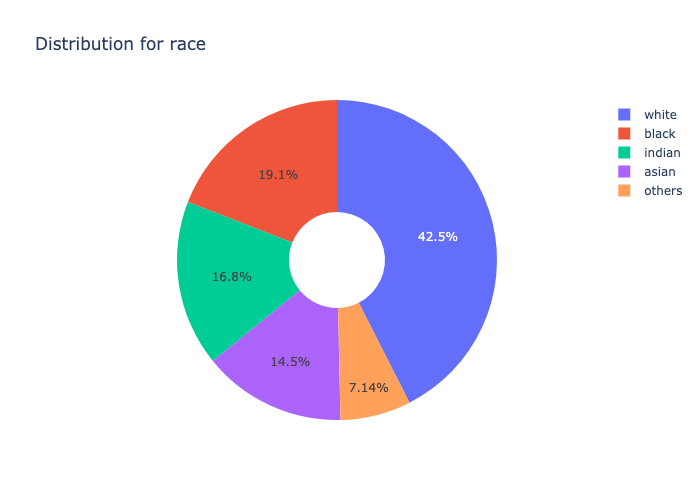

In [7]:
plot_distribution(df['race'])

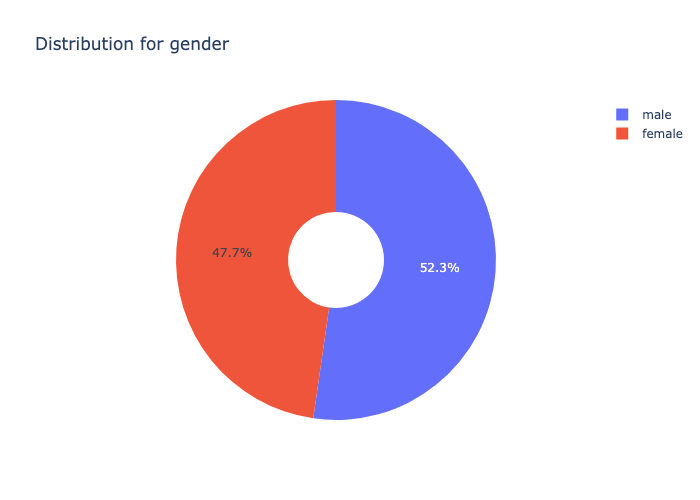

In [8]:
plot_distribution(df['gender'])

In [9]:
import plotly.express as px
fig = px.histogram(df, x="age", nbins=20)
fig.update_layout(title_text='Age distribution')
fig.show()

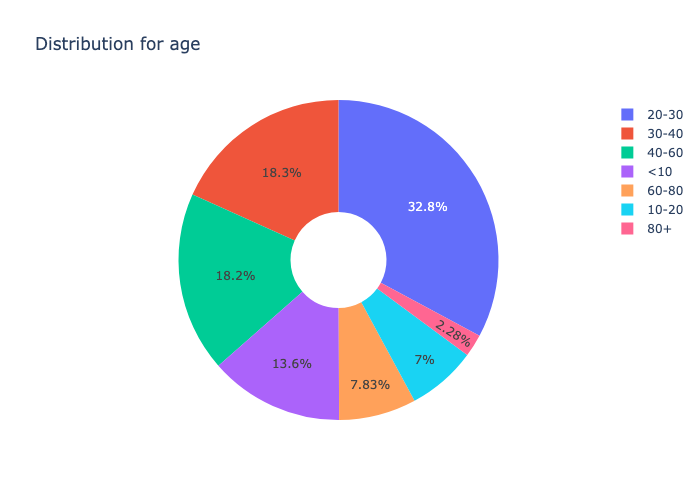

In [10]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']

age_binned = pd.cut(df['age'], bins, labels=names)
plot_distribution(age_binned)

In [86]:
from keras.utils import to_categorical
from PIL import Image

class UtkFaceDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]

        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_alias'][race])

        self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # lists to store our batched data
        batch_images = []
        batch_ages = []
        batch_races = []
        batch_genders = []
        
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age']
                race = person['race_id']
                gender = person['gender_id']
                file = person['file']
                
                im = self.preprocess_image(file)
                
                age_normalized = age / self.max_age
                race_categorical = to_categorical(race, len(dataset_dict['race_id']))
                gender_categorical = to_categorical(gender, len(dataset_dict['gender_id']))
                
                batch_images.append(im)
                batch_ages.append(age_normalized)
                batch_races.append(race_categorical)
                batch_genders.append(gender_categorical)
                
                # yielding condition
                if len(batch_images) >= batch_size:
                    yield np.array(batch_images), (np.array(batch_ages), np.array(batch_races), np.array(batch_genders))
                    batch_images = []
                    batch_ages = []
                    batch_races = []
                    batch_genders = []
                    
            if not is_training:
                break 

                    
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

In [13]:
from keras.models import Model
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Lambda, Dense, Flatten, Input
import tensorflow as tf

class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        return x

    def build_race_branch(self, inputs, num_races):
        """
        Used to build the race branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)

        return x

    def build_gender_branch(self, inputs, num_genders=2):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)

        return x

    def build_age_branch(self, inputs):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.

        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)

        return x

    def assemble_full_model(self, width, height, num_races):
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 3)

        inputs = Input(shape=input_shape)

        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)

        model = Model(inputs=inputs,
                     outputs = [age_branch, race_branch, gender_branch],
                     name="face_net")

        return model
    
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=len(dataset_dict['race_alias']))

In [14]:
model.summary()

Model: "face_net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 198, 198,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 198, 198,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 198, 198,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 198, 198,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 198, 198,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 198, 198,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 198, 198,  │          0 │ conv2d_6[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 198, 198,  │         64 │ activation[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 198, 198,  │         64 │ activation_4[0][… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 198, 198,  │         64 │ activation_8[0][… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 66, 66,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 66, 66,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 66, 66,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 66, 66,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 66, 66,    │          0 │ max_pooling2d_3[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 66, 66,    │          0 │ max_pooling2d_6[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 66, 66,    │      4,640 │ dropout[0][0]   

 Total params: 3,192,648 (12.18 MB)

 Trainable params: 3,191,400 (12.17 MB)

 Non-trainable params: 1,248 (4.88 KB)

In [ ]:
from keras.optimizers import Adam

init_lr = 1e-4
epochs = 100

opt = Adam(learning_rate=init_lr)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse', 
                  'race_output': 'categorical_crossentropy', 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4., 
                  'race_output': 1.5, 
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae', 
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})

In [ ]:
from keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint.keras", monitor='val_loss')
]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

In [15]:
model.save('./final-model.keras')

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['race_output_accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_race_output_accuracy'],
                    name='Valid'))


fig.update_layout(height=450, 
                  width=600,
                  title='Accuracy for race feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')

fig.write_html('acc_race.html', include_plotlyjs='cdn')

fig.show()

In [ ]:
plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['gender_output_accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_gender_output_accuracy'],
                    name='Valid'))


fig.update_layout(height=450, 
                  width=600,
                  title='Accuracy for gender feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')

fig.write_html('acc_gender.html', include_plotlyjs='cdn')

fig.show()

In [ ]:
plt.clf()

fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['age_output_mae'],
                    name='Train'))

fig.add_trace(go.Scattergl(
                    y=history.history['val_age_output_mae'],
                    name='Valid'))


fig.update_layout(height=450, 
                  width=600,
                  title='Mean Absolute Error for age feature',
                  xaxis_title='Epoch',
                  yaxis_title='Mean Absolute Error')

fig.write_html('mae_age.html', include_plotlyjs='cdn')

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scattergl(
                    y=history.history['val_loss'],
                    name='Valid'))


fig.update_layout(height=450, 
                  width=600,
                  title='Overall loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')

fig.write_html('overall_loss.html', include_plotlyjs='cdn')

fig.show()


In [87]:
from keras.models import load_model

model = load_model("model_checkpoint.keras")

In [88]:
test_batch_size = 128
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
age_pred, race_pred, gender_pred = model.predict(test_generator, 
                                                           steps=len(test_idx)//test_batch_size)

55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 719ms/step


In [90]:
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, age_true, race_true, gender_true = [], [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]

    images.extend(image)
    age_true.extend(labels[0])
    race_true.extend(labels[1])
    gender_true.extend(labels[2])
    
age_true = np.array(age_true)
race_true = np.array(race_true)
gender_true = np.array(gender_true)

race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)

age_true = age_true * data_generator.max_age
age_pred = age_pred * data_generator.max_age

In [ ]:
!pip3 install scikit-learn

In [19]:
from sklearn.metrics import classification_report

cr_race = classification_report(race_true, race_pred, target_names=dataset_dict['race_alias'].keys())
print(cr_race)

              precision    recall  f1-score   support

       white       0.88      0.95      0.92      3002
       black       0.94      0.88      0.91      1341
       asian       0.92      0.89      0.91       994
      indian       0.85      0.87      0.86      1208
      others       0.83      0.56      0.67       495

    accuracy                           0.89      7040
   macro avg       0.88      0.83      0.85      7040
weighted avg       0.89      0.89      0.89      7040



In [20]:
cr_gender = classification_report(gender_true, gender_pred, target_names=dataset_dict['gender_alias'].keys())
print(cr_gender)

              precision    recall  f1-score   support

        male       0.97      0.91      0.94      3651
      female       0.91      0.97      0.94      3389

    accuracy                           0.94      7040
   macro avg       0.94      0.94      0.94      7040
weighted avg       0.94      0.94      0.94      7040



In [21]:
from sklearn.metrics import r2_score

print('R2 score for age: ', r2_score(age_true, age_pred))

R2 score for age:  0.804445202954787


/var/folders/1_/blm5ws2x1xldyp8hd9kjclqw0000gn/T/ipykernel_71363/2625015441.py:26: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



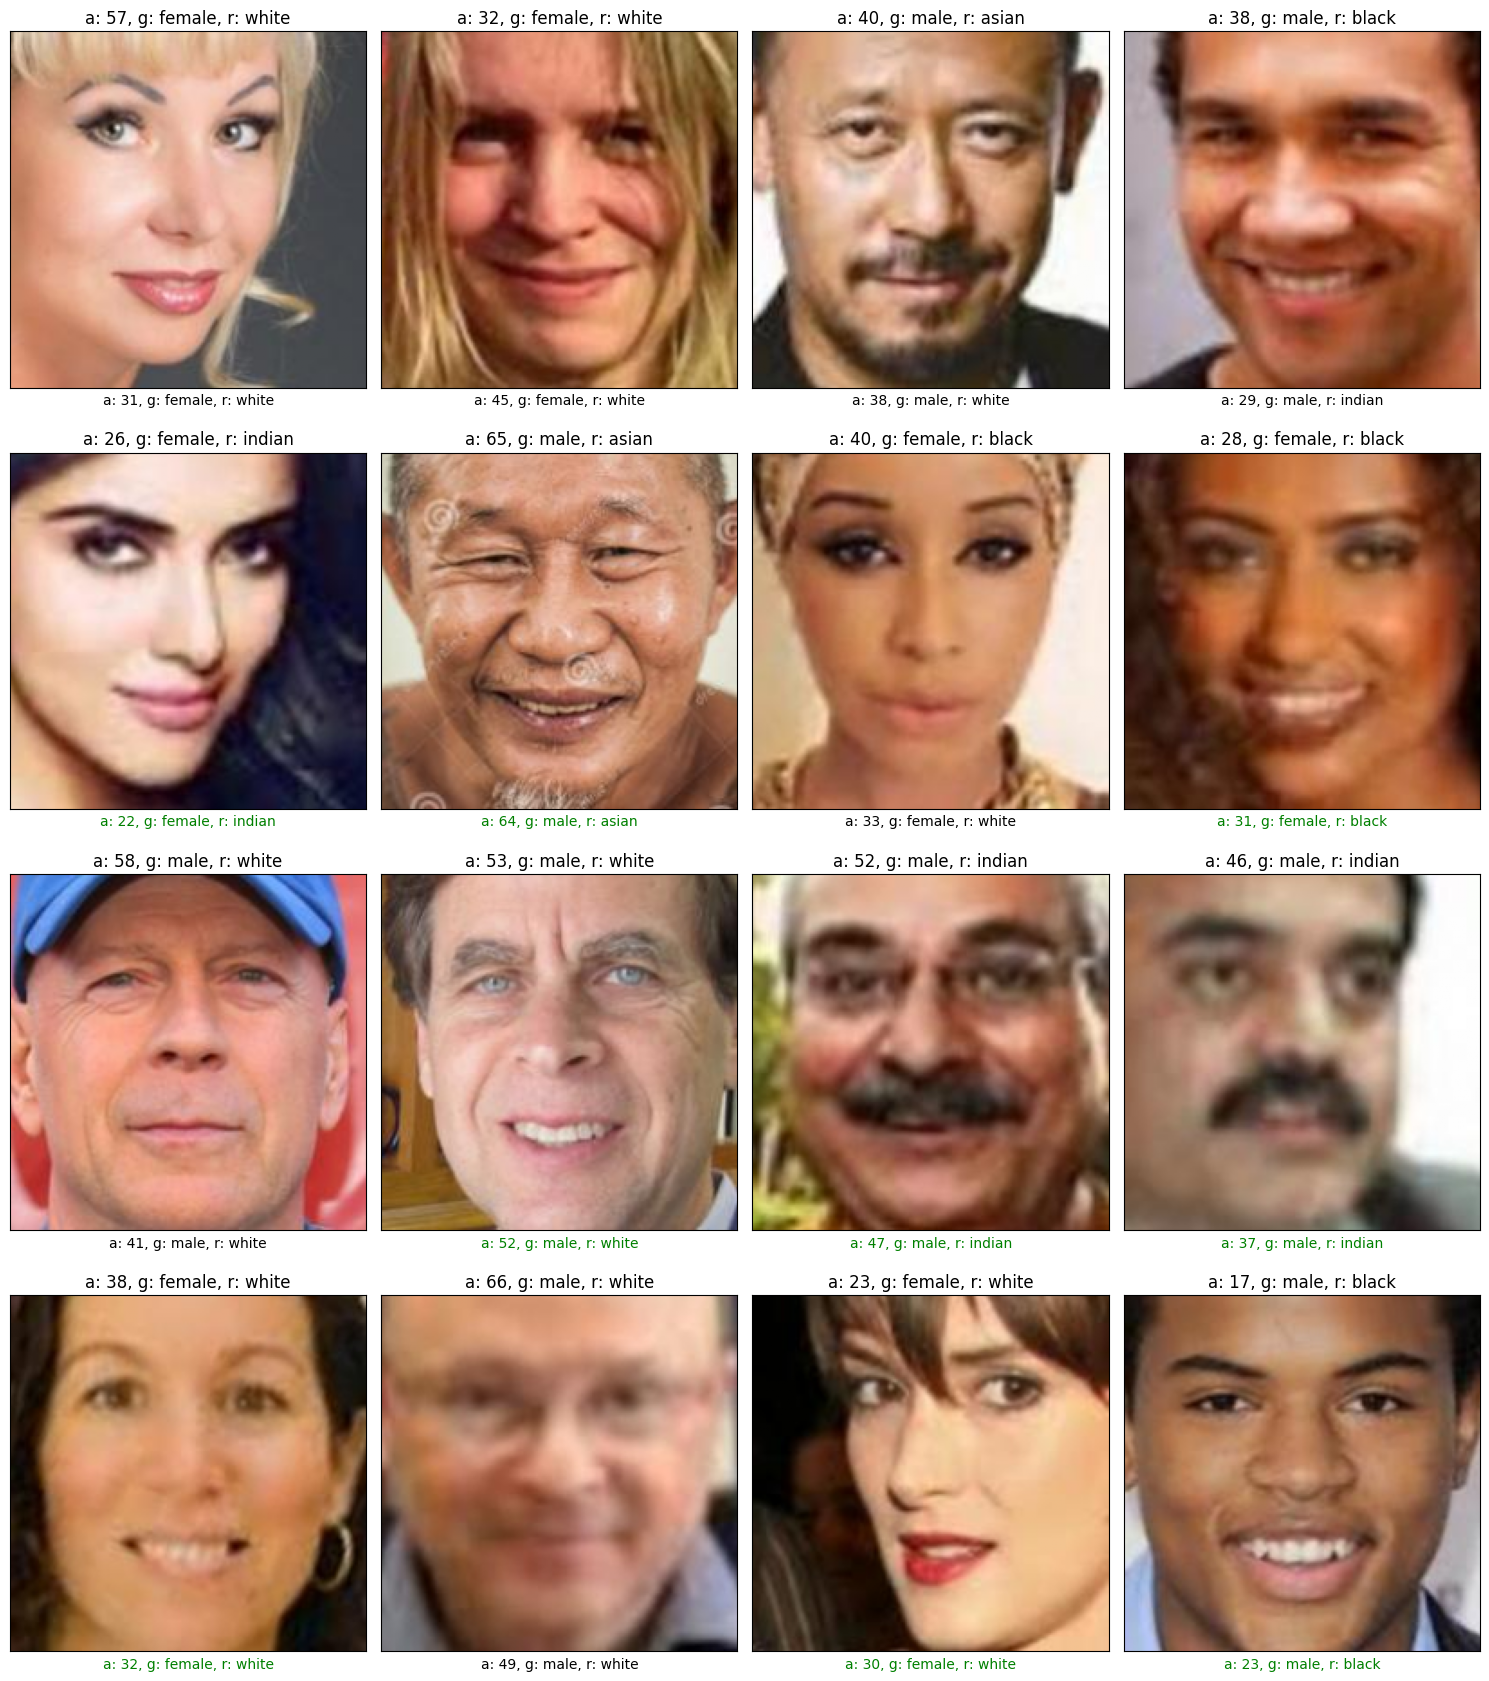

In [91]:
import math
n = 16
random_indices = np.random.permutation(n)
n_cols = 4
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(images[img_idx])
    
    cur_age_pred = age_pred[img_idx]
    cur_age_true = age_true[img_idx]
    
    cur_gender_pred = gender_pred[img_idx]
    cur_gender_true = gender_true[img_idx]
    
    cur_race_pred = race_pred[img_idx]
    cur_race_true = race_true[img_idx]
    
    age_threshold = 10
    if cur_gender_pred == cur_gender_true and cur_race_pred == cur_race_true and abs(cur_age_pred - cur_age_true) <= age_threshold:
        ax.xaxis.label.set_color('green')
    elif cur_gender_pred != cur_gender_true and cur_race_pred != cur_race_true and abs(cur_age_pred - cur_age_true) > age_threshold:
        ax.xaxis.label.set_color('red')
    
    ax.set_xlabel('a: {}, g: {}, r: {}'.format(int(age_pred[img_idx]),
                            dataset_dict['gender_id'][gender_pred[img_idx]],
                               dataset_dict['race_id'][race_pred[img_idx]]))
    
    ax.set_title('a: {}, g: {}, r: {}'.format(int(age_true[img_idx]),
                            dataset_dict['gender_id'][gender_true[img_idx]],
                               dataset_dict['race_id'][race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.savefig('preds.png')

In [92]:
from PIL import Image

img_path = "face_images/face_0.jpg"

im = Image.open(img_path)
im = im.convert('RGB')
im = im.resize((198, 198))
im = np.array(im) / 255.0

input_data = np.expand_dims(im, axis=0)

predictions = model.predict(input_data)

# Extract predictions
predicted_race_id = np.argmax(predictions[1])
predicted_gender_id = np.argmax(predictions[2])
            
# Map gender and race predictions to their corresponding labels
predicted_gender = dataset_dict['gender_id'].get(predicted_gender_id, 'Unknown')
predicted_race = dataset_dict['race_id'].get(predicted_race_id, 'Unknown')
            
# Output the results
print("Predicted Gender:", predicted_gender)
print("Predicted Race:", predicted_race)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
Predicted Gender: male
Predicted Race: indian
